In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import re
from sklearn.cluster import KMeans

startRampPath = 'data/BLM/start_ramp'

In [2]:
def getRowWithBlmMax(fill):
    """
    Parameters
        fill : DataFrame -- DataFrame loaded from the BLM data fill file, without timestamp column
    Returns
        DataFrame with row with the max BLM value in the provided data
    """
    maxes = fill.max(axis=1)  # row index -> max for that row
    maxOverallIdx = maxes.idxmax() # row index where max overall in fill can be found
    
    return fill.loc[maxOverallIdx] # row containing max overall

In [3]:
#TODO rename to filenames - not files
def loadFillFiles(phasePath):
    files = sorted(os.listdir(phasePath))
    files = [file for file in files if file.endswith('.txt')] # keep only text files - filter out files such as desktop.ini
    print(files) # To confirm that fills have been loaded in chronological order
    
    return files

In [4]:
def getMergedPhaseLosses(phasePath, maxFills):
    """
    Parameters
        phasePath : string - path containing fill files for a particular phase
        #TODO check for trailing / - or see if there are python function path functions that handle this for you
        maxFills : int - maximum number of fills to process.  -1 to process all fill files.
    Returns
        DataFrame with row with the max BLM value in the provided data
    """
    files = loadFillFiles(phasePath)
    phaseLosses = pd.DataFrame() # in each fill the row with the highest loss is chosen and appended to this DataFrame

    maxLossRows = []
    for i, file in enumerate(files):
        if i == maxFills:
            break

        # load fill file into a DataFrame
        fill = pd.read_csv(phasePath + '/' + file, sep=' ', header=None)
        # Delete first column (contains timestamps)
        fill = fill.drop(columns=0)
        # Extract the fill number from the filename (used eventually as the key for the row extracted from this fill)
        fillNo = re.search(r'\d+', file).group()

        # extract from the fill the row with the maximum loss
        rowWithMaxLoss = getRowWithBlmMax(fill)
        rowWithMaxLoss.name = fillNo
        maxLossRows.append(rowWithMaxLoss)
        
    phaseLosses = phaseLosses.append(maxLossRows)
        
    blmLabels = np.genfromtxt('data/blm_labels.txt', dtype='str')
    beam1BlmLabels = np.genfromtxt('data/beam1_blm_labels.txt', dtype='str')
    beam2BlmLabels = np.genfromtxt('data/beam2_blm_labels.txt', dtype='str')
    logicalBlmLabels = np.genfromtxt('data/logical_blm_labels.txt', dtype='str')

    phaseLosses.columns = blmLabels

    # Separate beam 1 losses and beam 2 losses
    beam1PhaseLosses = phaseLosses.filter(items=beam1BlmLabels); 
    beam2PhaseLosses = phaseLosses.filter(items=beam2BlmLabels);

    beam1PhaseLosses.columns = logicalBlmLabels 
    beam2PhaseLosses.columns = logicalBlmLabels

    # merge beam 1 losses and beam 2 losses under the same logical BLM labels
    mergedPhaseLosses = pd.concat([beam1PhaseLosses, beam2PhaseLosses], keys=['B1', 'B2'])
    
    return mergedPhaseLosses

In [5]:
maxFills = 5
mergedPhaseLosses = getMergedPhaseLosses(startRampPath, maxFills)

['Fill_6925_start_ramp.txt', 'Fill_6927_start_ramp.txt', 'Fill_6928_start_ramp.txt', 'Fill_6929_start_ramp.txt', 'Fill_6931_start_ramp.txt', 'Fill_6938_start_ramp.txt', 'Fill_6939_start_ramp.txt', 'Fill_6940_start_ramp.txt', 'Fill_6942_start_ramp.txt', 'Fill_6944_start_ramp.txt', 'Fill_6946_start_ramp.txt', 'Fill_6952_start_ramp.txt', 'Fill_6953_start_ramp.txt', 'Fill_6956_start_ramp.txt', 'Fill_6957_start_ramp.txt', 'Fill_6960_start_ramp.txt', 'Fill_6961_start_ramp.txt', 'Fill_6962_start_ramp.txt', 'Fill_6963_start_ramp.txt', 'Fill_6964_start_ramp.txt', 'Fill_6966_start_ramp.txt', 'Fill_6967_start_ramp.txt', 'Fill_6972_start_ramp.txt', 'Fill_6973_start_ramp.txt', 'Fill_6974_start_ramp.txt', 'Fill_6975_start_ramp.txt', 'Fill_6976_start_ramp.txt', 'Fill_6978_start_ramp.txt', 'Fill_6979_start_ramp.txt', 'Fill_6980_start_ramp.txt', 'Fill_6981_start_ramp.txt', 'Fill_6984_start_ramp.txt', 'Fill_6988_start_ramp.txt', 'Fill_6989_start_ramp.txt', 'Fill_6990_start_ramp.txt', 'Fill_6991_start_ra

In [6]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(mergedPhaseLosses)
print("Cluster memberships:\n{}".format(kmeans.labels_))

Cluster memberships:
[0 0 0 0 0 0 1 0 0 1]


<IPython.core.display.Javascript object>


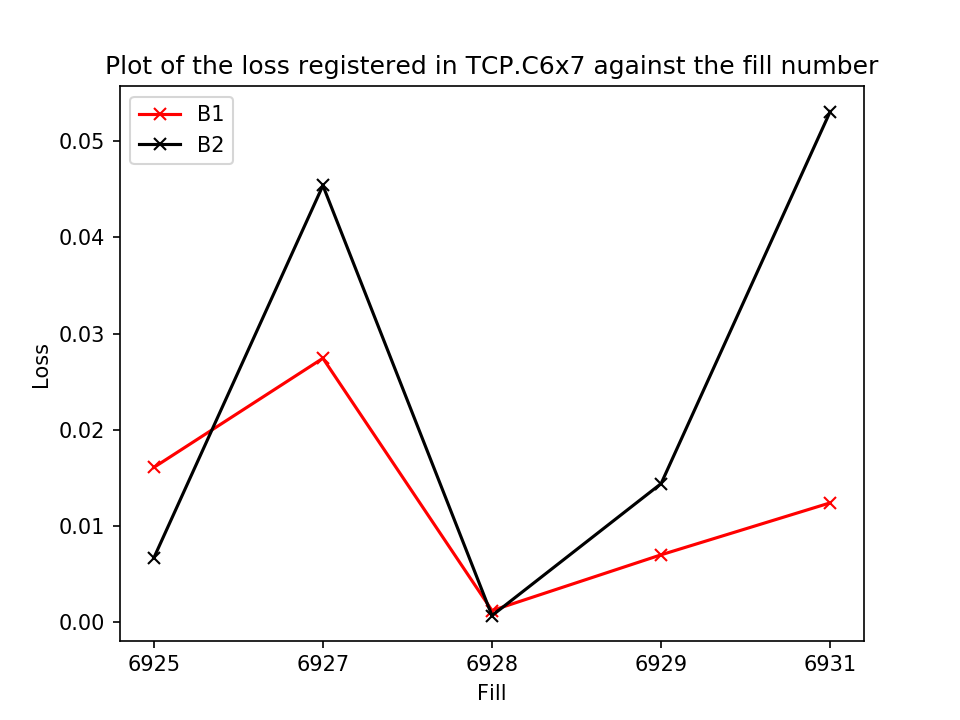

Text(0, 0.5, 'Loss')

In [7]:
# Data
df = pd.DataFrame({
    'B1': mergedPhaseLosses.loc['B1']['TCP.C6x7'],
    'B2': mergedPhaseLosses.loc['B2']['TCP.C6x7']
})
 
# multiple line plot
plt.figure()
plt.plot('B1', data=df, marker='x', color='red')
plt.plot('B2', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of the loss registered in TCP.C6x7 against the fill number')
plt.xlabel('Fill')
plt.ylabel('Loss')


<IPython.core.display.Javascript object>


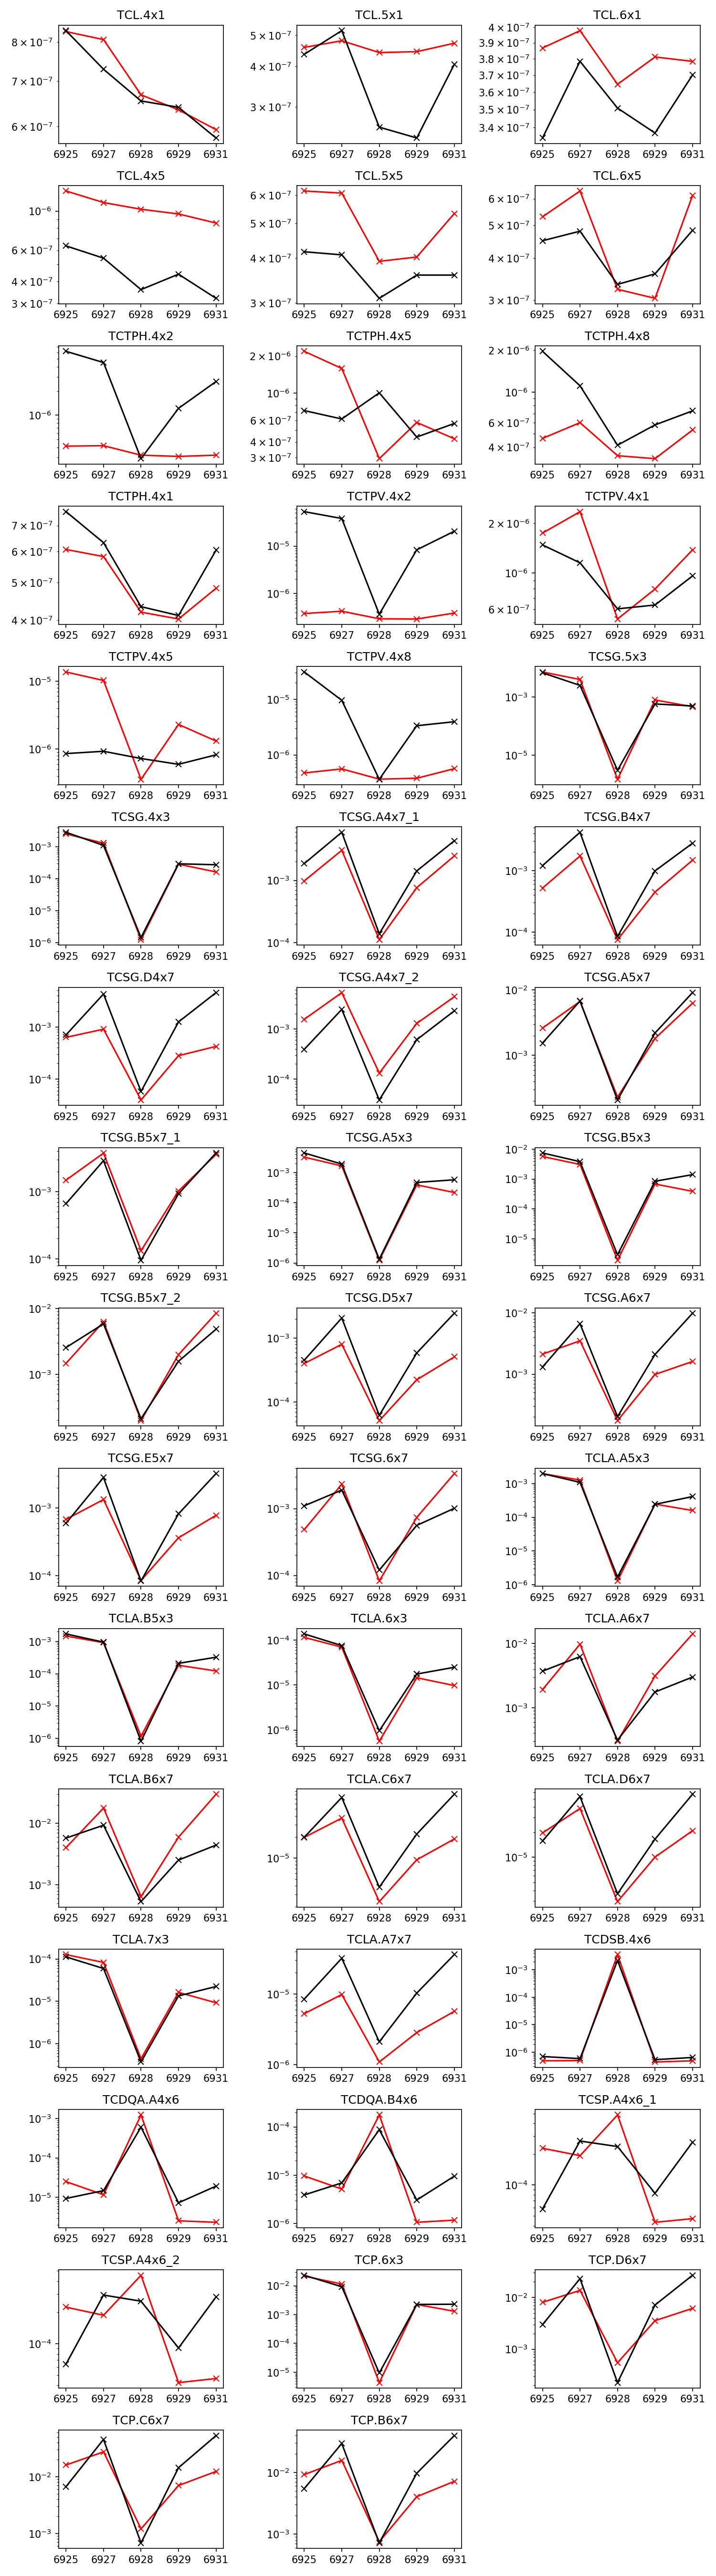

In [8]:
plt.figure(figsize=(10, 36))
ncols = 3;
nrows = math.ceil(mergedPhaseLosses.shape[1] / ncols)
i = 1;
for column in mergedPhaseLosses:
    # Data
    df = pd.DataFrame({
        'B1': mergedPhaseLosses.loc['B1'][column],
        'B2': mergedPhaseLosses.loc['B2'][column]
    })
 
    plt.subplot(nrows, ncols, i)
    plt.yscale('log')
    plt.plot('B1', data=df, marker='x', color='red')
    plt.plot('B2', data=df, marker='x', color='black')
    plt.title(column)

    
    i = i + 1
    

plt.tight_layout()

In [9]:
#To get Euclidean distance between the BLM vectors for beam 1 and beam 2
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

distance = cdist(mergedPhaseLosses.loc['B1'].values, mergedPhaseLosses.loc['B2'].values, metric='euclidean').diagonal()
#getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
#eg. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
#row 1 of B2 values, and so on.

#to confirm values are correct:
print(distance)
print(euclidean(mergedPhaseLosses.loc['B1'].iloc[0], mergedPhaseLosses.loc['B2'].iloc[0]))
print(euclidean(mergedPhaseLosses.loc['B1'].iloc[1], mergedPhaseLosses.loc['B2'].iloc[1]))
print(euclidean(mergedPhaseLosses.loc['B1'].iloc[2], mergedPhaseLosses.loc['B2'].iloc[2]))


[0.01218755 0.02712671 0.00166997 0.01082156 0.06335923]
0.012187554725641404
0.027126712341282815
0.001669969753250794


<IPython.core.display.Javascript object>


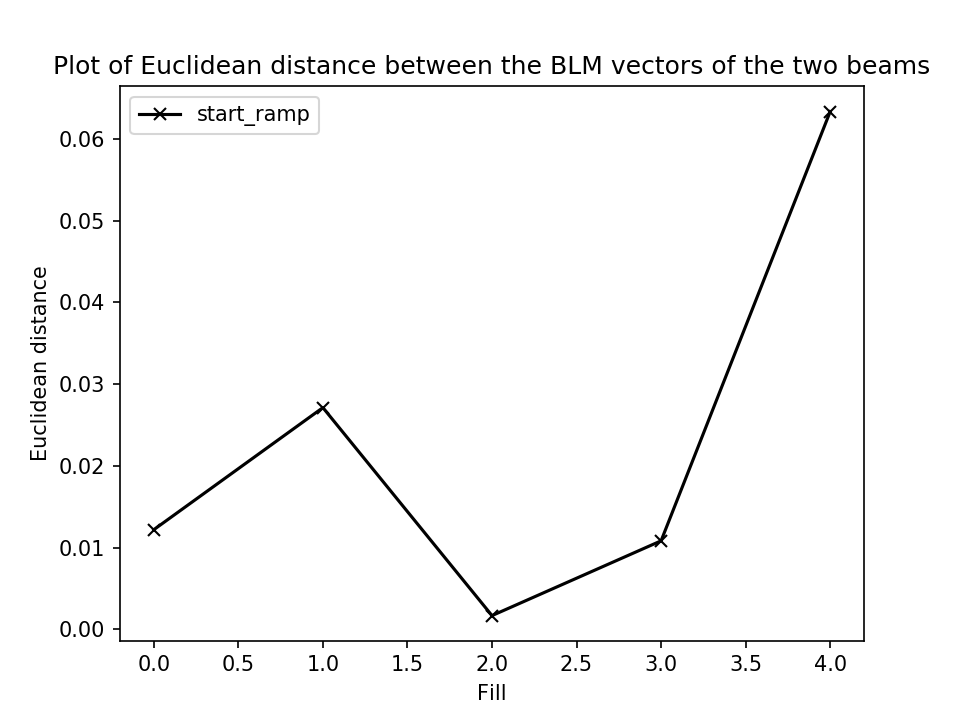

Text(0, 0.5, 'Euclidean distance')

In [10]:
# To plot Euclidean between the vectors (TCP, TCSG, ...) for beam 1 and beam 2
# Data
df = pd.DataFrame({
    'start_ramp': distance
})
 
# multiple line plot
plt.figure()
plt.plot('start_ramp', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of Euclidean distance between the BLM vectors of the two beams')
plt.xlabel('Fill')
plt.ylabel('Euclidean distance')